#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt 
from matplotlib.ticker import FormatStrFormatter

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from datetime import datetime
import sys

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

USE_CUDA = False
EPOCHS = 10
comms_round = 20

2025-10-25 11:26:23.414900: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-25 11:26:23.475255: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-25 11:26:23.515325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761380783.554941    4732 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761380783.568215    4732 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761380783.652421    4732 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Dataset

In [2]:
%store -r Fed_X_Train_st
%store -r Fed_X_Test_st

%store -r Fed_y_Train
%store -r Fed_y_Test

merged_dataset = pd.concat([Fed_X_Train_st, Fed_y_Train], axis=1)
Fed_X_Test_st = Fed_X_Test_st.drop(columns=['unit_number'])

In [3]:
feature_columns = ['time_cycles', 'LPC_Outlet_Temperature', 'HPC_Outlet_Temperature', 'LPT Outlet Temperature', 'Bypass-Duct Pressure', 
                'HPC Outlet Pressure', 'Physical Fan Speed', 'Physical Core Speed', 'HPC Outlet Static Pressure',
                'Ratio of Fuel Flow to Ps30', 'Corrected Fan Speed', 'Bypass Ratio', 'Bleed Enthalpy',
                'High-Pressure Turbines Cool Air Flow', 'Low-Pressure Turbines Cool Air Flow']

features = merged_dataset[feature_columns]

labels = merged_dataset['RUL']

### Data Partition

In [4]:
grouped = merged_dataset.groupby('unit_number')

unit_numbers = merged_dataset['unit_number'].unique()

np.random.seed(42)
np.random.shuffle(unit_numbers)

num_clients = 10
unit_subsets = np.array_split(unit_numbers, num_clients)

client_data = {f"client_{i+1}": pd.DataFrame() for i in range(num_clients)}

for i, unit_subset in enumerate(unit_subsets):
    client_data[f"client_{i+1}"] = grouped.filter(lambda x: x.name in unit_subset)

for i in range(num_clients):
    print(f"Client {i+1} dataset size: {len(client_data[f'client_{i+1}'])}")

client_1_data = client_data["client_1"]
client_2_data = client_data["client_2"]
client_3_data = client_data["client_3"]
client_4_data = client_data["client_4"]
client_5_data = client_data["client_5"]
client_6_data = client_data["client_6"]
client_7_data = client_data["client_7"]
client_8_data = client_data["client_8"]
client_9_data = client_data["client_9"]
client_10_data = client_data["client_10"]

Client 1 dataset size: 2174
Client 2 dataset size: 1896
Client 3 dataset size: 2054
Client 4 dataset size: 2237
Client 5 dataset size: 2031
Client 6 dataset size: 1878
Client 7 dataset size: 2046
Client 8 dataset size: 2024
Client 9 dataset size: 2082
Client 10 dataset size: 2209


In [5]:
client_1_data = client_data["client_1"].drop(columns=['unit_number'], errors='ignore')
client_2_data = client_data["client_2"].drop(columns=['unit_number'], errors='ignore')
client_3_data = client_data["client_3"].drop(columns=['unit_number'], errors='ignore')
client_4_data = client_data["client_4"].drop(columns=['unit_number'], errors='ignore')
client_5_data = client_data["client_5"].drop(columns=['unit_number'], errors='ignore')
client_6_data = client_data["client_6"].drop(columns=['unit_number'], errors='ignore')
client_7_data = client_data["client_7"].drop(columns=['unit_number'], errors='ignore')
client_8_data = client_data["client_8"].drop(columns=['unit_number'], errors='ignore')
client_9_data = client_data["client_9"].drop(columns=['unit_number'], errors='ignore')
client_10_data = client_data["client_10"].drop(columns=['unit_number'], errors='ignore')

#### Train, Test split for each one of the 10 datasets

In [6]:
datasets = []

for i, df in enumerate([client_1_data, client_2_data, client_3_data, client_4_data, client_5_data, 
                        client_6_data, client_7_data, client_8_data, client_9_data, client_10_data]):
    
    features = df[feature_columns]
    labels = df['RUL']
    
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, random_state=0)
    
    datasets.append({
        'name': f'dataset_{i+1}',
        'train_features': train_features,
        'test_features': test_features,
        'train_labels': train_labels,
        'test_labels': test_labels
    })

### LSTM Model

In [7]:
def create_lstm_model(input_shape):
    model = Sequential([
        layers.Reshape((input_shape, 1), input_shape=(input_shape,)),
        layers.LSTM(32, return_sequences=True, activation="tanh"),
        layers.Dropout(0.2),  
        layers.LSTM(64, activation="tanh", return_sequences=True),
        layers.Dropout(0.2), 
        layers.LSTM(32, activation="tanh"),
        layers.Dropout(0.2),  
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),  
        layers.Dense(1)
    ])
    model.compile(
        loss="mse", 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=["mae"]
    )
    return model

input_shape = len(train_features.columns)
lstm_model = create_lstm_model(input_shape)

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
E0000 00:00:1761380785.702663    4732 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1761380785.706311    4732 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
'''
def create_lstm_model(input_shape):
    model = Sequential([
        layers.Reshape((input_shape, 1), input_shape=(input_shape,)),
        layers.LSTM(32, activation="relu", return_sequences=True),
        layers.Dropout(0.1), 
        layers.LSTM(64, activation="relu", return_sequences=True),
        layers.Dropout(0.2), 
        layers.LSTM(128, activation="relu"),
        layers.Dropout(0.3), 
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.4), 
        layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model


input_shape = len(train_features.columns)
lstm_model = create_lstm_model(input_shape)
'''

'\ndef create_lstm_model(input_shape):\n    model = Sequential([\n        layers.Reshape((input_shape, 1), input_shape=(input_shape,)),\n        layers.LSTM(32, activation="relu", return_sequences=True),\n        layers.Dropout(0.1), \n        layers.LSTM(64, activation="relu", return_sequences=True),\n        layers.Dropout(0.2), \n        layers.LSTM(128, activation="relu"),\n        layers.Dropout(0.3), \n        layers.Dense(128, activation="relu"),\n        layers.Dropout(0.4), \n        layers.Dense(1)\n    ])\n    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))\n    return model\n\n\ninput_shape = len(train_features.columns)\nlstm_model = create_lstm_model(input_shape)\n'

In [9]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    
    if np.isnan(predictions).any():
        raise ValueError("Model predictions contain NaNs.")
    
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    
    return mae, rmse, r2

#### Function for KRUM

In [10]:
def krum(weights, num_byzantine):
    n = len(weights)
    num_layers = len(weights[0]) 
    distances = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            distance = 0
            for layer in range(num_layers):
                distance += np.linalg.norm(weights[i][layer] - weights[j][layer])
            distances[i, j] = distance
            distances[j, i] = distance
    
    scores = np.zeros(n)
    for i in range(n):
        scores[i] = np.sum(np.sort(distances[i])[:n - num_byzantine - 2])
    
    return weights[np.argmin(scores)]

### Federated Learning System with FedMA AGGREGATION

In [11]:
global_model = create_lstm_model(input_shape)

global_stats_mae_4 = pd.DataFrame(columns=['Round'] + [str(i) for i in range(len(datasets))] + ['test'])
global_stats_rmse_4 = pd.DataFrame(columns=['Round'] + [str(i) for i in range(len(datasets))] + ['test'])
global_stats_r2_4 = pd.DataFrame(columns=['Round'] + [str(i) for i in range(len(datasets))] + ['test'])


for comm_round in range(comms_round):
    print('Round', comm_round)
    global_weights = global_model.get_weights()
    client_weights = []
    
    for dataset in datasets:
        local_model = create_lstm_model(input_shape)
        local_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['MAE'])

        def scheduler(epoch):
            if epoch < 5:
                return 0.001
            else:
                return 0.0001

        callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
        local_model.set_weights(global_weights)

        epochs = EPOCHS 
        history = local_model.fit(dataset['train_features'], dataset['train_labels'], epochs=epochs, callbacks=[callback])

        client_weights.append(local_model.get_weights())

        for dataset_1 in datasets:
            mae, rmse, r2 = evaluate_model(local_model, dataset_1['test_features'], dataset_1['test_labels'])
            print(f'Evaluation results for {dataset["name"]} on {dataset_1["name"]} in round {comm_round}: MAE={mae}, RMSE={rmse}, R²={r2}')               

        mae, rmse, r2 = evaluate_model(local_model, dataset['test_features'], dataset['test_labels'])
        print(f'Evaluation results for {dataset["name"]} on itself in round {comm_round}: MAE={mae}, RMSE={rmse}, R²={r2}')

        K.clear_session()

    num_byzantine = 2  # Υποθέτουμε ότι υπάρχουν 2 Byzantine clients
    aggregated_weights = krum(client_weights, num_byzantine)

    global_model.set_weights(aggregated_weights)

    global_row_mae = [comm_round]
    global_row_rmse = [comm_round]
    global_row_r2 = [comm_round]

    for dataset in datasets:
        mae, rmse, r2 = evaluate_model(global_model, dataset['test_features'], dataset['test_labels'])
        global_row_mae.append(mae)
        global_row_rmse.append(rmse)
        global_row_r2.append(r2)
        print(f'Global evaluation results for {dataset["name"]} in round {comm_round}: MAE={mae}, RMSE={rmse}, R²={r2}')

    # Evaluate on the separate test dataset
    test_mae, test_rmse, test_r2 = evaluate_model(global_model, Fed_X_Test_st, Fed_y_Test)
    global_row_mae.append(test_mae)
    global_row_rmse.append(test_rmse)
    global_row_r2.append(test_r2)
    print(f'Global evaluation results on test dataset in round {comm_round}: MAE={test_mae}, RMSE={test_rmse}, R²={test_r2}')

    global_stats_mae_4.loc[len(global_stats_mae_4)] = global_row_mae
    global_stats_r2_4.loc[len(global_stats_r2_4)] = global_row_r2
    global_stats_rmse_4.loc[len(global_stats_rmse_4)] = global_row_rmse

print("Training completed.")

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Round 0
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 86.8490 - loss: 9378.9150 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 71.0679 - loss: 6631.5869 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 53.8287 - loss: 3776.9697 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 43.3001 - loss: 2315.1982 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 39.4345 - loss: 1993.4813 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.2760 - loss: 2021.0046 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.2094 - loss: 1991.0220 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.0895 - loss: 1992.0117 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.2276 - loss: 1991.5569 - learning_rate: 1.0000e-04
Epoch 10/10
4

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 82.7801 - loss: 8684.0459 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 69.8828 - loss: 6566.7021 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 54.8170 - loss: 4141.0239 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 44.7066 - loss: 2596.4607 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 40.7003 - loss: 2096.6111 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.6735 - loss: 1990.8031 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.6552 - loss: 2014.4899 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.9211 - loss: 2021.9785 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.6914 - loss: 1994.9098 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 86.6406 - loss: 9330.0078 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 72.5920 - loss: 6884.7266 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 57.1481 - loss: 4334.2295 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 45.5866 - loss: 2609.5835 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 40.8006 - loss: 2083.7400 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.6242 - loss: 2028.6824 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.6160 - loss: 2013.8057 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 40.0108 - loss: 2037.7284 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.7203 - loss: 2036.7220 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 87.0927 - loss: 9472.6387 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 67.8703 - loss: 6048.0605 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 50.6891 - loss: 3270.2129 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 42.1166 - loss: 2183.0959 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.2877 - loss: 2000.4670 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.4570 - loss: 2039.5480 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.1096 - loss: 1993.8024 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.6455 - loss: 2040.3881 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.3284 - loss: 2005.5000 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 84.9269 - loss: 9033.7988 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 69.6537 - loss: 6464.6631 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 52.6328 - loss: 3728.7480 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 42.6399 - loss: 2289.4146 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.7068 - loss: 2021.5079 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.1852 - loss: 1977.9681 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 38.8645 - loss: 1956.5511 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 38.9594 - loss: 1976.3405 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.3624 - loss: 1978.0360 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 81.6421 - loss: 8479.8633 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 69.0946 - loss: 6448.5718 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 55.5654 - loss: 4281.2871 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 45.6358 - loss: 2747.1013 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 40.9298 - loss: 2121.2520 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.5295 - loss: 1991.1963 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.3677 - loss: 1977.4037 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.3862 - loss: 1990.4479 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.5861 - loss: 2026.6785 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 85.8922 - loss: 9169.7354 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 72.1242 - loss: 6840.7998 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 56.9431 - loss: 4343.9756 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 45.3596 - loss: 2653.4907 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 40.8209 - loss: 2070.7332 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.4711 - loss: 1979.9724 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.5583 - loss: 1988.4209 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.3766 - loss: 1974.2075 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.1977 - loss: 1971.8235 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 85.3804 - loss: 9105.2041 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 71.5300 - loss: 6722.3765 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 56.1788 - loss: 4216.5322 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 45.7095 - loss: 2654.7458 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 41.1217 - loss: 2126.3743 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 40.0275 - loss: 2017.2781 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 40.1368 - loss: 2041.9023 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 40.0606 - loss: 2045.5039 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.7507 - loss: 2010.5491 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 86.9549 - loss: 9363.8691 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 73.1267 - loss: 6991.7886 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 57.7894 - loss: 4371.0103 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 45.4609 - loss: 2613.7502 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 40.2518 - loss: 2057.9155 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.4850 - loss: 2018.5807 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.2976 - loss: 1996.1191 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.4884 - loss: 2016.5786 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.1135 - loss: 1995.3452 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 87.9257 - loss: 9571.3252 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 71.7617 - loss: 6763.1489 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 54.2691 - loss: 3834.1277 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 43.8253 - loss: 2363.5276 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.8825 - loss: 1998.8470 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.5777 - loss: 2001.4845 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.5378 - loss: 2022.7594 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.6026 - loss: 2030.2705 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 39.1965 - loss: 1980.4730 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 31.2404 - loss: 1334.5703 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.8624 - loss: 675.6491 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.1101 - loss: 615.0156 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.5024 - loss: 590.8588 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.3399 - loss: 576.2967 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.4357 - loss: 579.2567 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.2440 - loss: 562.4160 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.2194 - loss: 561.6554 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.6726 - loss: 596.0150 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 31.7294 - loss: 1358.2412 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.9255 - loss: 616.4644 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8654 - loss: 467.6754 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3653 - loss: 455.0778 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9479 - loss: 479.2880 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4742 - loss: 460.5371 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7787 - loss: 421.1459 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5888 - loss: 468.2233 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4998 - loss: 465.7868 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 32.0987 - loss: 1401.7462 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 22.4201 - loss: 772.8867 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 21.2166 - loss: 712.4359 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.6599 - loss: 683.7903 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.2713 - loss: 661.9620 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.0897 - loss: 632.9876 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.3572 - loss: 660.1038 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.5538 - loss: 678.2151 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.2885 - loss: 655.3952 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 31.2131 - loss: 1341.4579 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.2216 - loss: 656.4756 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.7165 - loss: 586.6099 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.3162 - loss: 555.8422 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7052 - loss: 533.6431 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6011 - loss: 522.8199 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6097 - loss: 521.5545 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.9276 - loss: 544.7071 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4373 - loss: 512.8033 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 31.6502 - loss: 1378.0619 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.3752 - loss: 641.0393 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.7822 - loss: 645.4275 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.7983 - loss: 589.7170 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.7441 - loss: 576.4953 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.8834 - loss: 581.7823 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.7023 - loss: 587.0972 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.3115 - loss: 565.3495 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.9966 - loss: 602.0102 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 33.4047 - loss: 1493.1885 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 23.3172 - loss: 798.5855 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.2722 - loss: 653.3637 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.9360 - loss: 653.5777 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.8127 - loss: 643.1490 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.3020 - loss: 600.6522 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.9311 - loss: 638.5747 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.7475 - loss: 623.9590 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.0520 - loss: 587.7605 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 31.6589 - loss: 1365.4637 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 21.0230 - loss: 709.4644 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.8876 - loss: 717.7069 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.7842 - loss: 703.4947 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.5036 - loss: 679.8265 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.0474 - loss: 670.2391 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.9395 - loss: 655.9296 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.5755 - loss: 625.5117 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.6776 - loss: 636.9075 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 31.9091 - loss: 1360.7964 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.7672 - loss: 656.0219 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.1462 - loss: 608.7128 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.5645 - loss: 563.8531 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.3823 - loss: 552.8403 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5077 - loss: 508.3336 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.4965 - loss: 558.9135 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7682 - loss: 518.5591 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6811 - loss: 523.2995 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 32.2829 - loss: 1403.3445 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 21.2730 - loss: 683.1160 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.0341 - loss: 653.1680 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.3206 - loss: 616.7374 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.3846 - loss: 615.4732 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.1505 - loss: 613.6640 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.8939 - loss: 587.5253 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.6531 - loss: 583.5513 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.7637 - loss: 643.2297 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 32.8646 - loss: 1443.0669 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 21.4175 - loss: 709.0396 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.0782 - loss: 663.9777 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.7389 - loss: 643.1047 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.0445 - loss: 608.4872 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.2299 - loss: 622.9376 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.1822 - loss: 599.6251 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.1314 - loss: 623.0449 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.9468 - loss: 591.6161 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.8509 - loss: 597.7084 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.6851 - loss: 597.7033 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.6112 - loss: 595.1910 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.8482 - loss: 559.5759 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0120 - loss: 556.0129 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.8186 - loss: 537.7538 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4789 - loss: 532.6752 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0392 - loss: 562.5862 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4167 - loss: 539.2477 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.6834 - loss: 470.8279 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3835 - loss: 458.2586 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7549 - loss: 425.5293 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3465 - loss: 452.4196 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7802 - loss: 469.1164 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1824 - loss: 455.3251 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8694 - loss: 424.0225 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5149 - loss: 411.6046 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6584 - loss: 421.4647 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 20.6012 - loss: 691.4960 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.8967 - loss: 680.9432 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.4948 - loss: 678.7763 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.3011 - loss: 655.1683 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.9067 - loss: 641.7519 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.9824 - loss: 646.2823 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.8404 - loss: 633.9401 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.9705 - loss: 647.9335 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.1570 - loss: 644.7327 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 19.0842 - loss: 590.7657 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7887 - loss: 540.9619 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6245 - loss: 538.5725 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3967 - loss: 531.1336 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7969 - loss: 508.2417 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3714 - loss: 473.8207 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5071 - loss: 477.0137 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2858 - loss: 480.5198 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3711 - loss: 469.5789 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 19.2952 - loss: 610.8116 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.0928 - loss: 597.6879 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.5384 - loss: 623.7775 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.6329 - loss: 587.5209 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.6663 - loss: 590.7247 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0788 - loss: 552.8598 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.2322 - loss: 573.7320 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7925 - loss: 539.4380 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7768 - loss: 557.2951 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 19.7501 - loss: 632.9288 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.1106 - loss: 599.0514 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.2874 - loss: 606.2229 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.2641 - loss: 629.2053 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.2014 - loss: 619.1606 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.2323 - loss: 609.7383 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.7118 - loss: 593.2667 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.8114 - loss: 604.2872 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.2970 - loss: 578.1796 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 20.3679 - loss: 675.4012 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.1466 - loss: 663.2207 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.1785 - loss: 681.0709 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.8514 - loss: 658.6548 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.6706 - loss: 637.7799 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.4763 - loss: 629.3618 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.5755 - loss: 649.8996 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.2788 - loss: 625.2361 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.4323 - loss: 633.6706 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.8420 - loss: 525.2765 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0495 - loss: 546.7958 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5444 - loss: 503.5785 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3954 - loss: 470.5721 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.9444 - loss: 533.8893 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0782 - loss: 494.5432 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7352 - loss: 485.1703 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2963 - loss: 500.3794 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4785 - loss: 516.6895 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 19.5047 - loss: 619.6818 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.7191 - loss: 579.8154 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.1158 - loss: 607.9579 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.1475 - loss: 604.4895 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.0279 - loss: 600.8976 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.6289 - loss: 590.8104 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.1383 - loss: 570.7682 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.3852 - loss: 567.9459 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.6533 - loss: 594.8679 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 19.7610 - loss: 644.5668 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.2217 - loss: 618.9460 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.1834 - loss: 615.5894 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.9768 - loss: 616.6492 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.4772 - loss: 581.5107 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.0868 - loss: 620.2709 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.0121 - loss: 613.2260 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.4991 - loss: 583.1311 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.9009 - loss: 614.4240 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.3779 - loss: 520.7299 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.8154 - loss: 566.4592 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5494 - loss: 542.2570 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9613 - loss: 508.2733 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5054 - loss: 542.6108 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7860 - loss: 496.8656 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8823 - loss: 517.1968 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4040 - loss: 542.5161 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1575 - loss: 520.5961 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.1817 - loss: 447.5746 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1159 - loss: 449.5062 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5625 - loss: 425.6125 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3035 - loss: 417.4200 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1460 - loss: 404.5677 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2642 - loss: 398.2177 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7953 - loss: 376.1974 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9469 - loss: 387.7775 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2478 - loss: 400.7913 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 19.5062 - loss: 630.7286 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 20.0956 - loss: 651.8228 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.5778 - loss: 639.6994 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.3583 - loss: 599.5496 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.9983 - loss: 600.5400 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.8054 - loss: 580.6729 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.1094 - loss: 603.0266 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.9240 - loss: 589.7680 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.6147 - loss: 568.3934 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.8612 - loss: 553.5927 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0175 - loss: 503.7416 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1265 - loss: 500.0424 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4284 - loss: 474.7480 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6236 - loss: 483.0551 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5176 - loss: 478.2536 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9139 - loss: 448.0402 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9860 - loss: 448.1045 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8408 - loss: 437.9657 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 19.2205 - loss: 623.2116 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.6526 - loss: 589.2605 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0232 - loss: 560.6512 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5646 - loss: 526.9902 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.9547 - loss: 550.5430 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5507 - loss: 531.4088 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4470 - loss: 524.3668 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.2218 - loss: 570.7740 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6403 - loss: 539.7036 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.8106 - loss: 603.6913 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.5484 - loss: 586.7679 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.6515 - loss: 587.2595 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.6719 - loss: 593.7249 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.5687 - loss: 594.6030 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.4166 - loss: 563.1074 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.9525 - loss: 546.6930 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.2727 - loss: 559.2209 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5339 - loss: 523.6891 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 20.7389 - loss: 702.5461 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.6759 - loss: 653.4630 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.6199 - loss: 630.6278 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.3070 - loss: 628.7866 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.8079 - loss: 613.5552 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.0385 - loss: 614.2879 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.6984 - loss: 587.8749 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.7283 - loss: 594.8084 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.0303 - loss: 602.5980 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.9513 - loss: 496.5247 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0691 - loss: 511.6784 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2037 - loss: 496.5779 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2932 - loss: 456.2723 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2286 - loss: 453.5090 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3484 - loss: 463.1167 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9182 - loss: 435.7337 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2738 - loss: 454.9995 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2724 - loss: 464.9397 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.6604 - loss: 597.9854 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.5800 - loss: 581.7268 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.5279 - loss: 580.9390 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.7013 - loss: 592.6171 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.1012 - loss: 563.3648 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.4955 - loss: 578.8245 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.2725 - loss: 564.4565 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6032 - loss: 546.7982 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5076 - loss: 524.0790 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.8001 - loss: 599.4864 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.4027 - loss: 634.2207 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.0878 - loss: 623.8148 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.6781 - loss: 607.9279 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.7562 - loss: 605.0244 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.1586 - loss: 578.6668 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.1455 - loss: 562.7339 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.2117 - loss: 558.0380 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0664 - loss: 560.2723 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.3946 - loss: 531.8421 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9423 - loss: 514.8895 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9698 - loss: 514.9052 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1145 - loss: 519.4296 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1458 - loss: 513.3312 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9082 - loss: 498.2447 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0812 - loss: 526.8122 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4792 - loss: 492.3246 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3497 - loss: 478.7017 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.0337 - loss: 394.9329 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9544 - loss: 386.4964 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2227 - loss: 404.5745 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9869 - loss: 395.9437 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1323 - loss: 399.5051 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3078 - loss: 353.9966 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3853 - loss: 364.8647 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3954 - loss: 363.5779 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4436 - loss: 366.8931 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 19.8633 - loss: 639.4711 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.0297 - loss: 592.0487 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.7028 - loss: 576.0604 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.8854 - loss: 592.3677 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.1690 - loss: 605.0435 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.4201 - loss: 567.2678 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.4029 - loss: 569.6437 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.5601 - loss: 568.1348 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.3064 - loss: 560.7819 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.3301 - loss: 519.1964 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3192 - loss: 473.2164 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2304 - loss: 466.2151 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2570 - loss: 460.4691 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2006 - loss: 457.4986 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2649 - loss: 463.2169 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6787 - loss: 437.2425 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1220 - loss: 410.3986 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4978 - loss: 418.8163 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.6122 - loss: 580.6475 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2255 - loss: 521.0885 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7853 - loss: 494.3567 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2864 - loss: 519.0749 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0720 - loss: 564.9406 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1329 - loss: 527.7491 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1916 - loss: 517.1993 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9196 - loss: 494.1485 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4740 - loss: 481.6859 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.8279 - loss: 551.4597 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.3033 - loss: 580.7679 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.7388 - loss: 590.0975 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7779 - loss: 542.5514 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0758 - loss: 552.0878 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.9134 - loss: 559.2042 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0802 - loss: 513.1511 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1774 - loss: 511.4208 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5464 - loss: 540.0721 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 19.7882 - loss: 652.2770 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.3114 - loss: 579.3344 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.5392 - loss: 579.5820 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0392 - loss: 559.2331 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.9769 - loss: 543.2308 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6764 - loss: 535.8045 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7099 - loss: 540.6897 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5746 - loss: 527.3433 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7898 - loss: 549.2843 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.8914 - loss: 486.2281 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9148 - loss: 440.7981 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4785 - loss: 461.7161 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5613 - loss: 473.2174 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0076 - loss: 433.3883 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1555 - loss: 444.0354 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8993 - loss: 434.3532 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6714 - loss: 424.1471 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7743 - loss: 434.8651 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.5291 - loss: 577.4768 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7337 - loss: 546.8909 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0742 - loss: 558.8498 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.9530 - loss: 546.1069 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4952 - loss: 529.2133 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3202 - loss: 499.9458 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1589 - loss: 498.1598 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3993 - loss: 529.6537 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1170 - loss: 511.2079 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.3484 - loss: 579.2184 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.3528 - loss: 579.9674 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.4644 - loss: 578.6649 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.6992 - loss: 596.1311 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.3598 - loss: 569.9449 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.1973 - loss: 551.7587 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.9589 - loss: 552.1392 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.8675 - loss: 560.1204 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.1614 - loss: 563.6353 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.8087 - loss: 521.6614 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6670 - loss: 493.1875 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9952 - loss: 467.2164 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6358 - loss: 496.6227 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6079 - loss: 485.9872 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9020 - loss: 470.1082 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2483 - loss: 467.8245 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7602 - loss: 455.0528 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8418 - loss: 449.0443 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 14.8358 - loss: 381.3241 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4388 - loss: 369.5564 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8148 - loss: 382.1811 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2490 - loss: 346.2764 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4677 - loss: 369.2401 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4829 - loss: 362.8790 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.0758 - loss: 349.6154 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4699 - loss: 364.7255 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4264 - loss: 365.5023 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.6024 - loss: 576.0901 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.8291 - loss: 587.6519 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.7892 - loss: 592.2905 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 19.0961 - loss: 597.1339 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.6429 - loss: 583.2415 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.3262 - loss: 557.9654 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0667 - loss: 535.4052 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.8848 - loss: 538.6083 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0407 - loss: 538.4296 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.5916 - loss: 479.0894 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9708 - loss: 449.3754 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0008 - loss: 452.9701 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5735 - loss: 434.0089 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5740 - loss: 429.9835 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7186 - loss: 423.8451 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0554 - loss: 394.3168 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4353 - loss: 417.3331 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2224 - loss: 419.5801 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.6124 - loss: 532.0383 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0940 - loss: 503.2553 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3576 - loss: 521.3589 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7942 - loss: 489.1699 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4238 - loss: 462.9879 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1457 - loss: 466.6344 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6228 - loss: 480.6924 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9462 - loss: 450.2491 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0024 - loss: 449.0956 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.7213 - loss: 537.3510 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4379 - loss: 536.2572 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5084 - loss: 519.3654 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7014 - loss: 531.9984 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3091 - loss: 525.1725 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1856 - loss: 523.5839 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3523 - loss: 525.6600 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9065 - loss: 496.1857 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3135 - loss: 533.5166 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.9641 - loss: 602.7151 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.4246 - loss: 569.9041 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.2248 - loss: 561.7577 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.8624 - loss: 533.6712 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5500 - loss: 529.8424 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5160 - loss: 522.2878 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2036 - loss: 516.1716 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0920 - loss: 498.4095 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1657 - loss: 512.0009 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.5292 - loss: 461.2928 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5436 - loss: 421.9707 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4242 - loss: 420.8501 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0012 - loss: 437.0874 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4717 - loss: 406.9157 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0023 - loss: 388.5625 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8812 - loss: 382.5632 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6587 - loss: 431.9347 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0085 - loss: 393.0653 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.9970 - loss: 566.1041 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6417 - loss: 525.2061 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2982 - loss: 521.6029 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9199 - loss: 480.0439 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7016 - loss: 539.7665 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3021 - loss: 497.7665 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7165 - loss: 491.2934 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8943 - loss: 489.6424 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1539 - loss: 504.9357 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.3824 - loss: 577.8267 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.9120 - loss: 559.5125 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.4412 - loss: 572.7670 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.1351 - loss: 564.2109 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.8291 - loss: 550.6770 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.9863 - loss: 560.9909 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.1628 - loss: 562.7988 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0006 - loss: 558.9639 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6112 - loss: 525.1177 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.2075 - loss: 526.1095 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5239 - loss: 485.1738 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4245 - loss: 475.3235 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4506 - loss: 479.5333 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4855 - loss: 488.3903 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9024 - loss: 449.6099 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1373 - loss: 468.5092 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5786 - loss: 445.0269 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9474 - loss: 447.2704 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 14.4759 - loss: 363.8544 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6266 - loss: 375.5006 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7604 - loss: 381.4353 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.9912 - loss: 345.1491 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.1733 - loss: 339.5329 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.7441 - loss: 329.3877 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.9961 - loss: 351.7344 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.9858 - loss: 344.8601 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.6316 - loss: 327.5898 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.7223 - loss: 570.9556 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.4125 - loss: 552.5380 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.2258 - loss: 547.3981 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.8647 - loss: 527.8414 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7559 - loss: 526.5495 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6182 - loss: 515.8629 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7121 - loss: 518.8126 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6198 - loss: 525.0564 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2206 - loss: 493.8961 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.3129 - loss: 467.0981 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3817 - loss: 461.3733 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6913 - loss: 441.4569 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2531 - loss: 463.7549 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6818 - loss: 438.5469 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6255 - loss: 383.7498 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3665 - loss: 419.0218 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1541 - loss: 403.7799 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0900 - loss: 403.7682 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.3286 - loss: 527.8291 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3240 - loss: 523.3923 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8202 - loss: 510.0673 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1375 - loss: 498.2422 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5037 - loss: 484.6598 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9041 - loss: 438.2232 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1333 - loss: 457.8878 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2080 - loss: 471.1576 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6539 - loss: 438.0993 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.0876 - loss: 507.5875 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7487 - loss: 537.7924 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.9434 - loss: 550.5623 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3373 - loss: 515.9414 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8932 - loss: 491.6836 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0553 - loss: 508.1685 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0776 - loss: 517.7654 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5587 - loss: 477.3590 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9449 - loss: 491.1185 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.6502 - loss: 578.5703 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6353 - loss: 542.6393 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.2467 - loss: 574.8608 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6864 - loss: 535.6385 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6547 - loss: 534.4177 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4024 - loss: 504.4751 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9279 - loss: 501.9738 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0943 - loss: 500.7176 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8685 - loss: 503.4601 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.9538 - loss: 440.4471 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5225 - loss: 423.2376 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2135 - loss: 403.6054 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5759 - loss: 415.0202 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8528 - loss: 427.9449 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0796 - loss: 398.0088 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8198 - loss: 376.7941 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8698 - loss: 381.6489 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6829 - loss: 374.6436 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.1770 - loss: 511.2791 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0294 - loss: 499.0264 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4526 - loss: 513.0730 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1042 - loss: 499.9289 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2735 - loss: 511.8944 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0539 - loss: 496.2522 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3010 - loss: 509.2410 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7613 - loss: 492.5152 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4049 - loss: 456.2000 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 18.4793 - loss: 590.7493 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.4397 - loss: 570.0778 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0029 - loss: 555.5276 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0501 - loss: 575.2545 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.1440 - loss: 555.7604 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2666 - loss: 517.4917 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1261 - loss: 503.4676 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4043 - loss: 502.0566 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3852 - loss: 521.1648 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.6913 - loss: 501.2785 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6735 - loss: 487.9998 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3488 - loss: 474.7815 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9502 - loss: 453.3683 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3624 - loss: 478.0482 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9799 - loss: 463.7628 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8014 - loss: 458.7734 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8819 - loss: 458.6814 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7162 - loss: 450.7221 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 13.7874 - loss: 337.3429 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8498 - loss: 336.4672 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8287 - loss: 335.5300 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.1869 - loss: 348.6618 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.0410 - loss: 342.8796 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.6603 - loss: 322.8977 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.4323 - loss: 315.8033 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.9480 - loss: 337.4048 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.4427 - loss: 315.0190 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.5222 - loss: 565.6804 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.8713 - loss: 520.1850 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6926 - loss: 523.8129 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4702 - loss: 517.7344 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5956 - loss: 520.1323 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4277 - loss: 511.3050 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.9324 - loss: 529.4957 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7554 - loss: 478.4665 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3144 - loss: 506.7309 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.7679 - loss: 441.9651 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6327 - loss: 432.3671 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7666 - loss: 434.0596 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3725 - loss: 427.3354 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8020 - loss: 387.7752 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2212 - loss: 398.5983 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8565 - loss: 397.7792 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2284 - loss: 405.7244 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6166 - loss: 378.4466 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.6361 - loss: 484.5295 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0390 - loss: 518.3039 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4237 - loss: 474.7734 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1801 - loss: 463.5606 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4177 - loss: 481.9699 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7545 - loss: 434.9761 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2784 - loss: 427.5175 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2238 - loss: 457.3936 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8797 - loss: 435.7463 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.5516 - loss: 528.2682 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5498 - loss: 538.7518 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0793 - loss: 510.2216 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1687 - loss: 519.1569 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.8379 - loss: 544.1848 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8071 - loss: 493.6952 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8317 - loss: 497.6481 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6797 - loss: 485.1254 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8412 - loss: 488.6683 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.2352 - loss: 570.8885 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.2395 - loss: 550.8474 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2894 - loss: 522.3302 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4184 - loss: 524.3651 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1109 - loss: 510.8992 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3119 - loss: 520.1743 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8852 - loss: 504.7831 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9531 - loss: 495.2831 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0968 - loss: 502.5448 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.5066 - loss: 410.0920 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6691 - loss: 428.4951 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4912 - loss: 422.8682 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7302 - loss: 380.0413 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6929 - loss: 422.3427 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7474 - loss: 377.8902 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7460 - loss: 370.6866 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5868 - loss: 369.6068 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8590 - loss: 376.5013 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 17.1660 - loss: 497.8813 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3388 - loss: 507.9719 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9320 - loss: 496.7326 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1781 - loss: 497.6849 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0793 - loss: 506.1109 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4978 - loss: 466.7122 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7406 - loss: 469.9203 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8043 - loss: 487.5510 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6578 - loss: 470.1663 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.8539 - loss: 557.3057 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.2747 - loss: 564.9300 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4949 - loss: 530.0038 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0954 - loss: 542.4399 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2582 - loss: 520.4119 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6811 - loss: 537.3400 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4014 - loss: 525.7077 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5809 - loss: 524.0099 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6386 - loss: 532.9958 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.3619 - loss: 483.2074 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6509 - loss: 438.9731 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7551 - loss: 448.6642 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0458 - loss: 468.9770 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5519 - loss: 443.3004 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5022 - loss: 442.8372 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4460 - loss: 438.2080 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5888 - loss: 443.4147 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6447 - loss: 432.8308 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 14.6675 - loss: 372.5317 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.9218 - loss: 338.8792 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6250 - loss: 372.9353 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8853 - loss: 336.7531 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.6266 - loss: 325.4531 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.6019 - loss: 322.9884 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.0739 - loss: 337.8248 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.7840 - loss: 333.8590 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.4318 - loss: 313.7933 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.0221 - loss: 532.8765 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7300 - loss: 528.6674 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.1626 - loss: 554.3472 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1857 - loss: 506.2613 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1345 - loss: 498.8232 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2657 - loss: 505.5664 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1260 - loss: 497.7780 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2991 - loss: 508.5728 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6814 - loss: 465.7641 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.9341 - loss: 449.8413 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6317 - loss: 433.2835 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5362 - loss: 427.9950 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3742 - loss: 420.5444 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3405 - loss: 417.1411 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2711 - loss: 404.1118 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2880 - loss: 414.9851 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8988 - loss: 395.0327 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1969 - loss: 406.9886 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.2193 - loss: 513.5266 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5320 - loss: 486.5018 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7176 - loss: 495.2897 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0370 - loss: 456.0888 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1064 - loss: 457.4678 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6930 - loss: 433.0969 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8704 - loss: 443.2046 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9091 - loss: 447.8253 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8375 - loss: 440.3944 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 17.7411 - loss: 538.8954 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9807 - loss: 494.2533 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4563 - loss: 535.5932 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3770 - loss: 513.6569 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9414 - loss: 500.3258 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5793 - loss: 499.9431 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0270 - loss: 509.0874 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3054 - loss: 511.2621 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8553 - loss: 497.1827 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.5141 - loss: 576.2522 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.8814 - loss: 542.9929 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5625 - loss: 527.0994 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3680 - loss: 512.3190 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0084 - loss: 501.0355 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1160 - loss: 516.1806 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7478 - loss: 493.5978 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9136 - loss: 497.3099 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1057 - loss: 511.3730 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.6192 - loss: 420.6716 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3096 - loss: 406.9846 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1433 - loss: 398.0385 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3282 - loss: 404.4444 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4454 - loss: 398.8854 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7229 - loss: 379.1400 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7373 - loss: 367.5379 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5917 - loss: 372.7126 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8215 - loss: 374.1322 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.3819 - loss: 515.0576 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9043 - loss: 487.0173 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9149 - loss: 477.9962 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3114 - loss: 516.8625 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7710 - loss: 484.9694 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7690 - loss: 490.7313 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5762 - loss: 466.5665 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5608 - loss: 471.1908 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2675 - loss: 458.7984 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.3267 - loss: 568.9354 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.8692 - loss: 547.1137 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.1142 - loss: 551.3853 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7676 - loss: 541.0357 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4302 - loss: 512.4441 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1580 - loss: 514.2434 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1321 - loss: 498.9410 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0084 - loss: 498.7853 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6951 - loss: 527.9924 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.5918 - loss: 479.5638 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1394 - loss: 470.1883 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6129 - loss: 444.4908 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4820 - loss: 432.0958 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7570 - loss: 439.6485 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5101 - loss: 441.5459 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7516 - loss: 441.6460 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5179 - loss: 434.6783 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2657 - loss: 419.2630 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 14.4397 - loss: 353.8301 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.9326 - loss: 336.6666 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.5794 - loss: 320.6095 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8730 - loss: 332.7969 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8768 - loss: 332.1726 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.5534 - loss: 324.2551 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.7454 - loss: 327.7433 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.6164 - loss: 312.2547 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.5374 - loss: 313.3857 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 17.4558 - loss: 506.1225 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0612 - loss: 487.4918 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3049 - loss: 505.4347 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1177 - loss: 491.7751 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9855 - loss: 487.7287 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2845 - loss: 497.2507 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9604 - loss: 477.4982 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7806 - loss: 486.5739 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9292 - loss: 481.4691 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.1681 - loss: 456.0827 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6444 - loss: 434.4720 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4095 - loss: 414.5059 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8904 - loss: 397.5440 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4211 - loss: 419.8835 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4891 - loss: 363.3483 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3790 - loss: 373.8657 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4114 - loss: 371.5291 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3612 - loss: 372.1007 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.1931 - loss: 518.3231 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9597 - loss: 495.4016 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5381 - loss: 481.1302 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2606 - loss: 482.1371 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0584 - loss: 455.1178 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8886 - loss: 438.6760 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6361 - loss: 428.9721 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9678 - loss: 458.5451 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7717 - loss: 438.0070 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.1200 - loss: 504.7316 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9895 - loss: 508.5299 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0508 - loss: 501.3597 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0583 - loss: 459.2502 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1006 - loss: 506.6945 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2396 - loss: 452.6717 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1817 - loss: 466.0208 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4143 - loss: 459.9533 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3857 - loss: 470.9835 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 17.4299 - loss: 530.9385 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8156 - loss: 508.0266 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6124 - loss: 536.7531 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3257 - loss: 525.4531 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9722 - loss: 513.2458 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1184 - loss: 510.1462 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9873 - loss: 497.9973 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5311 - loss: 475.3730 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2716 - loss: 471.7516 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.5961 - loss: 413.8705 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0807 - loss: 397.1814 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1610 - loss: 389.5040 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4471 - loss: 359.2152 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2396 - loss: 392.7645 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6236 - loss: 364.1090 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7093 - loss: 370.6547 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4891 - loss: 367.1832 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6235 - loss: 358.6116 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.1793 - loss: 498.0303 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7137 - loss: 478.5746 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5342 - loss: 474.8911 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6826 - loss: 480.3489 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9861 - loss: 489.2741 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2972 - loss: 455.5520 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6331 - loss: 478.9372 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6056 - loss: 472.6135 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3449 - loss: 459.3957 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.1460 - loss: 566.4810 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.1186 - loss: 555.8672 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5290 - loss: 523.0201 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5673 - loss: 524.5677 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.8694 - loss: 534.9176 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2491 - loss: 521.3223 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7833 - loss: 534.5806 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7917 - loss: 485.5840 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3002 - loss: 511.8208 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.9709 - loss: 448.0572 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7042 - loss: 445.6460 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2945 - loss: 418.2675 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2899 - loss: 430.3918 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2110 - loss: 421.1038 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7833 - loss: 448.9431 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9400 - loss: 454.2248 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2508 - loss: 414.9667 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0155 - loss: 412.7821 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 14.0441 - loss: 333.3113 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.0664 - loss: 338.8535 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.1926 - loss: 344.1264 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.7871 - loss: 326.5603 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.7583 - loss: 322.7663 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.4880 - loss: 310.1573 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.5875 - loss: 314.8203 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.4641 - loss: 308.6609 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.7223 - loss: 313.8407 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.7180 - loss: 526.3633 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1910 - loss: 491.5424 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0796 - loss: 489.3737 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3474 - loss: 508.9084 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8935 - loss: 492.4236 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9912 - loss: 486.8810 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8555 - loss: 478.1658 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3089 - loss: 450.0353 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0604 - loss: 489.6219 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.4749 - loss: 422.9868 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3843 - loss: 415.4068 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0920 - loss: 397.7341 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8872 - loss: 392.7473 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5935 - loss: 382.5405 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4679 - loss: 373.0488 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9047 - loss: 395.5101 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5001 - loss: 371.0424 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8004 - loss: 392.3936 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.8441 - loss: 491.9557 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4389 - loss: 474.3763 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0429 - loss: 448.6122 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8780 - loss: 442.3097 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9643 - loss: 451.1174 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9503 - loss: 446.8834 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8610 - loss: 445.4685 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4981 - loss: 428.5130 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5866 - loss: 426.2296 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.4959 - loss: 528.0068 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6846 - loss: 489.8134 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1923 - loss: 517.7064 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9786 - loss: 500.5753 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5635 - loss: 467.8100 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1031 - loss: 453.7350 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9598 - loss: 447.9279 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2011 - loss: 460.1377 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4522 - loss: 468.6265 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 18.2426 - loss: 577.0742 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7733 - loss: 543.2975 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5809 - loss: 534.4290 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1671 - loss: 508.8580 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7496 - loss: 495.4340 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1247 - loss: 507.8586 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6976 - loss: 480.4917 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2682 - loss: 462.9662 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5725 - loss: 483.3781 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.8096 - loss: 428.7030 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8667 - loss: 386.6030 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4927 - loss: 378.3875 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7845 - loss: 377.6817 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0595 - loss: 388.1243 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7681 - loss: 367.3115 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4847 - loss: 367.3883 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4859 - loss: 370.8269 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6228 - loss: 359.9077 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.0330 - loss: 499.7894 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6302 - loss: 468.0027 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3854 - loss: 456.9868 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7758 - loss: 475.0539 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3987 - loss: 459.9844 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2082 - loss: 441.6735 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2558 - loss: 465.0316 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3337 - loss: 454.4819 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3088 - loss: 458.2598 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 17.6794 - loss: 548.2531 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.1127 - loss: 565.2114 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1241 - loss: 515.6016 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6237 - loss: 533.0342 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0211 - loss: 503.7982 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3758 - loss: 526.4789 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2523 - loss: 509.0292 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0293 - loss: 492.7008 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8706 - loss: 490.7433 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.2333 - loss: 428.6259 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6412 - loss: 444.7205 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8370 - loss: 446.4734 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7751 - loss: 444.5897 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5628 - loss: 434.9934 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1735 - loss: 415.6726 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2271 - loss: 414.6077 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8810 - loss: 406.0878 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1271 - loss: 429.3145 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 14.5145 - loss: 351.8608 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 13.7787 - loss: 327.5867 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.0122 - loss: 342.7264 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.0697 - loss: 335.9558 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.6477 - loss: 319.7993 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.6104 - loss: 327.2227 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.6106 - loss: 317.7335 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.3601 - loss: 306.4763 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.2741 - loss: 301.0156 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.7995 - loss: 524.5991 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0098 - loss: 492.4480 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2285 - loss: 489.8183 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2401 - loss: 503.6229 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0784 - loss: 498.2584 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7958 - loss: 469.2588 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8270 - loss: 479.6907 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1255 - loss: 488.4751 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6154 - loss: 461.0308 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.1458 - loss: 456.2651 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5255 - loss: 419.8126 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2751 - loss: 409.7597 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7445 - loss: 393.0859 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.1749 - loss: 369.7280 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2022 - loss: 358.3444 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2224 - loss: 359.3734 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4000 - loss: 374.3561 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2256 - loss: 367.4882 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.6446 - loss: 477.0550 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5449 - loss: 476.4069 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1334 - loss: 456.1147 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8843 - loss: 457.8439 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4450 - loss: 464.2326 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9233 - loss: 433.4561 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4373 - loss: 417.4071 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6896 - loss: 427.8837 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3959 - loss: 410.3967 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.7968 - loss: 492.5936 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9355 - loss: 494.4243 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6973 - loss: 503.3714 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1229 - loss: 452.1933 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9929 - loss: 497.2942 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9181 - loss: 501.4870 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8125 - loss: 437.7137 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5466 - loss: 474.3160 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2243 - loss: 454.2428 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.8445 - loss: 563.5768 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1939 - loss: 507.5714 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1347 - loss: 509.4591 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5395 - loss: 527.2441 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9670 - loss: 492.2626 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6622 - loss: 487.5695 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9936 - loss: 448.8472 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1804 - loss: 466.7476 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6642 - loss: 477.2778 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.1545 - loss: 399.2520 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2625 - loss: 403.1010 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6919 - loss: 366.2550 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0075 - loss: 390.0056 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6352 - loss: 364.3806 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6933 - loss: 380.7701 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2917 - loss: 352.0724 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2028 - loss: 344.4565 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4690 - loss: 349.1052 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.2613 - loss: 462.4255 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2629 - loss: 462.1894 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9719 - loss: 481.1355 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3032 - loss: 460.3165 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3345 - loss: 468.1692 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4399 - loss: 461.1800 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1800 - loss: 455.7198 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5219 - loss: 463.7419 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0296 - loss: 443.6432 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.9507 - loss: 543.7705 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6531 - loss: 528.8986 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7412 - loss: 542.5560 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1722 - loss: 507.2043 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3647 - loss: 517.3885 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4727 - loss: 516.3560 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8042 - loss: 486.7882 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9402 - loss: 500.8772 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9308 - loss: 485.1107 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 15.5881 - loss: 427.3299 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1210 - loss: 425.8504 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3283 - loss: 435.0069 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2228 - loss: 429.3855 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2588 - loss: 418.9839 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3067 - loss: 420.1339 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0397 - loss: 410.3312 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9576 - loss: 404.6659 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3635 - loss: 411.5835 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 14.2414 - loss: 349.9788 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.7550 - loss: 325.6279 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 13.6447 - loss: 321.5250 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8667 - loss: 326.9465 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.5107 - loss: 316.7021 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.5473 - loss: 314.3329 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.3800 - loss: 299.6093 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.3256 - loss: 309.0852 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.4071 - loss: 305.1292 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.3408 - loss: 501.0984 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0732 - loss: 480.5646 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9173 - loss: 480.4112 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1755 - loss: 494.9160 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6867 - loss: 525.2385 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4582 - loss: 461.5720 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5273 - loss: 466.8655 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5963 - loss: 461.5551 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4417 - loss: 461.8161 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.3775 - loss: 416.1635 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0679 - loss: 409.3916 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8819 - loss: 390.1653 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8595 - loss: 388.9889 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5198 - loss: 372.2484 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3482 - loss: 365.9444 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2551 - loss: 357.7795 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2475 - loss: 363.8512 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4429 - loss: 367.4546 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 16.8055 - loss: 503.6314 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9581 - loss: 496.2609 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1473 - loss: 459.6385 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5827 - loss: 429.1183 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2626 - loss: 461.8152 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5026 - loss: 427.1261 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3870 - loss: 424.7261 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5596 - loss: 417.5564 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2249 - loss: 413.4649 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 16.5203 - loss: 476.0846 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1314 - loss: 514.6370 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7740 - loss: 489.7473 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3507 - loss: 474.4128 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6180 - loss: 472.8728 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7958 - loss: 428.7493 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8803 - loss: 442.0980 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2155 - loss: 461.0425 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9696 - loss: 437.4453 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.0800 - loss: 574.7172 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8411 - loss: 497.0211 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7922 - loss: 486.6926 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7522 - loss: 495.0977 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9534 - loss: 498.4094 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3800 - loss: 466.4394 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8746 - loss: 448.4314 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4086 - loss: 471.9768 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9653 - loss: 460.0230 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 14.8268 - loss: 374.8597 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9342 - loss: 380.5408 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1490 - loss: 395.1880 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5612 - loss: 363.8413 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7371 - loss: 379.7247 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4836 - loss: 358.8459 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.1331 - loss: 343.6782 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2918 - loss: 364.4639 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2882 - loss: 350.8961 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 16.6928 - loss: 476.2556 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3600 - loss: 464.2253 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5249 - loss: 468.8373 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3106 - loss: 464.9393 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5253 - loss: 471.8369 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2386 - loss: 446.9106 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9259 - loss: 454.2119 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1545 - loss: 457.6078 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4474 - loss: 468.1379 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 18.1388 - loss: 563.6929 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.8141 - loss: 542.1662 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 18.0042 - loss: 547.1594 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3946 - loss: 512.9639 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5904 - loss: 525.5848 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2048 - loss: 509.5882 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3676 - loss: 516.8494 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9941 - loss: 494.8120 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1231 - loss: 498.5840 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.5298 - loss: 434.4242 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0188 - loss: 417.7110 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4261 - loss: 421.3229 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5450 - loss: 441.1215 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9368 - loss: 401.8952 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6337 - loss: 393.9667 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0276 - loss: 410.6552 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1263 - loss: 410.2003 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8270 - loss: 405.9811 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 14.4429 - loss: 360.1408 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.7291 - loss: 322.4658 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.6290 - loss: 319.7498 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.6335 - loss: 317.1671 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.5063 - loss: 316.5937 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.2727 - loss: 309.6903 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.2526 - loss: 302.9559 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.2882 - loss: 312.8763 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.2181 - loss: 298.8466 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.9935 - loss: 483.7260 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0520 - loss: 493.9362 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6390 - loss: 471.1445 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9809 - loss: 488.2756 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4719 - loss: 470.5921 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3906 - loss: 452.2235 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9581 - loss: 444.1343 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7506 - loss: 465.8102 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0175 - loss: 437.7823 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.8157 - loss: 434.9930 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 14.7418 - loss: 375.2716 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7688 - loss: 382.9096 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3803 - loss: 372.6645 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5035 - loss: 363.7115 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5492 - loss: 371.0760 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4885 - loss: 370.7955 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2106 - loss: 351.7083 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2982 - loss: 375.2676 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 16.2004 - loss: 468.5903 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1857 - loss: 455.0382 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9830 - loss: 441.8758 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2068 - loss: 460.6982 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8749 - loss: 442.9146 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7674 - loss: 432.8792 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6813 - loss: 421.9231 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1681 - loss: 408.7610 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2421 - loss: 415.5850 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.8476 - loss: 493.2206 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4727 - loss: 480.7810 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4834 - loss: 471.5291 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2998 - loss: 468.2576 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2671 - loss: 461.8828 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8827 - loss: 451.7434 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8091 - loss: 440.1086 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4092 - loss: 412.7114 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8928 - loss: 436.6371 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.9053 - loss: 557.4135 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.6743 - loss: 526.0175 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5128 - loss: 520.2247 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3971 - loss: 469.3080 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5850 - loss: 475.1542 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1945 - loss: 464.9217 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3825 - loss: 472.6516 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9971 - loss: 449.9345 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4615 - loss: 425.3708 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.4560 - loss: 403.6677 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4731 - loss: 413.0905 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9816 - loss: 393.1239 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8015 - loss: 375.8670 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7022 - loss: 376.0999 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2337 - loss: 350.3684 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5427 - loss: 356.7979 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.1455 - loss: 351.1178 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.9006 - loss: 332.4733 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.9805 - loss: 494.3027 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4217 - loss: 467.9673 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5052 - loss: 472.8883 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8217 - loss: 490.9429 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9315 - loss: 476.9810 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5592 - loss: 470.4158 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1494 - loss: 446.3164 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8591 - loss: 427.5463 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4591 - loss: 472.2998 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 17.9097 - loss: 551.0083 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3963 - loss: 497.3303 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 17.1529 - loss: 506.5571 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9544 - loss: 503.3191 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.9242 - loss: 531.7673 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1334 - loss: 500.7265 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9279 - loss: 501.9418 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1292 - loss: 499.1459 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2786 - loss: 508.6505 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.2275 - loss: 418.1876 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 15.5022 - loss: 434.5930 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4121 - loss: 432.4406 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4253 - loss: 424.9400 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0062 - loss: 412.7358 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0166 - loss: 415.4608 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8344 - loss: 397.0503 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6328 - loss: 395.7456 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4721 - loss: 386.9868 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 14.2693 - loss: 347.7316 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8114 - loss: 330.4799 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.2954 - loss: 303.9826 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.0095 - loss: 296.1851 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.3857 - loss: 311.1589 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.3191 - loss: 300.9247 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.5447 - loss: 303.1992 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.0304 - loss: 295.1875 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.7825 - loss: 277.8771 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.1058 - loss: 489.9370 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6944 - loss: 475.2386 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5424 - loss: 472.6132 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6848 - loss: 473.3275 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7334 - loss: 475.3556 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3832 - loss: 440.3746 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3096 - loss: 445.6931 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2377 - loss: 455.3367 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5311 - loss: 458.2441 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 15.2135 - loss: 409.7702 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2921 - loss: 418.5937 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7191 - loss: 439.0029 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6432 - loss: 380.2134 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8635 - loss: 382.7836 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.1722 - loss: 351.5162 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8478 - loss: 347.2437 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2242 - loss: 366.6160 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2516 - loss: 364.7352 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.3993 - loss: 472.1838 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3058 - loss: 445.8313 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5208 - loss: 432.6461 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6430 - loss: 441.6144 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7120 - loss: 437.7714 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2181 - loss: 407.1787 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6120 - loss: 381.6490 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0778 - loss: 400.7114 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3567 - loss: 411.2231 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.0572 - loss: 516.4582 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5379 - loss: 473.0544 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4425 - loss: 481.2727 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1389 - loss: 464.2912 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4388 - loss: 483.1011 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4888 - loss: 469.3574 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5754 - loss: 430.8500 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9681 - loss: 448.8993 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0143 - loss: 446.7606 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 17.8229 - loss: 549.5330 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3691 - loss: 514.5980 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0909 - loss: 495.9357 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9703 - loss: 501.0618 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4596 - loss: 476.2827 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3487 - loss: 465.3093 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4129 - loss: 471.0052 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2785 - loss: 461.2180 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0501 - loss: 444.8865 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - MAE: 14.6927 - loss: 383.2359 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 14.3545 - loss: 360.5553 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 14.6192 - loss: 355.5468 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 14.6919 - loss: 369.8958 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 14.5434 - loss: 366.8207 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 14.1183 - loss: 337.0723 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 14.3078 - loss: 359.3402 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3372 - loss: 354.5533 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.1004 - loss: 326.4409 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 16.5083 - loss: 470.6139 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2881 - loss: 456.5429 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3597 - loss: 459.8627 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3460 - loss: 469.5766 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3031 - loss: 452.4487 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 15.8055 - loss: 428.7876 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0414 - loss: 440.7248 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1625 - loss: 444.6771 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8159 - loss: 439.2831 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.7831 - loss: 542.9858 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.7558 - loss: 539.5622 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4080 - loss: 518.0369 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2563 - loss: 507.3496 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5811 - loss: 528.7261 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6696 - loss: 486.1669 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8766 - loss: 481.8094 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0794 - loss: 493.0560 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9930 - loss: 492.1233 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 14.9954 - loss: 410.9431 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9662 - loss: 406.2172 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1750 - loss: 415.8074 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1205 - loss: 423.4433 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2263 - loss: 429.2343 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2868 - loss: 434.8056 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9868 - loss: 410.0178 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4301 - loss: 384.7164 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5846 - loss: 391.0059 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 13.7341 - loss: 320.2820 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.3978 - loss: 301.7739 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.2197 - loss: 305.6159 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.6921 - loss: 316.8596 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.5512 - loss: 305.2792 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.0912 - loss: 298.2773 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.5587 - loss: 279.8747 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.1198 - loss: 293.7787 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.2497 - loss: 296.4517 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 17.1841 - loss: 489.5681 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 16.7700 - loss: 492.9655 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1649 - loss: 483.0140 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6995 - loss: 475.3535 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5097 - loss: 466.4997 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1595 - loss: 441.3636 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8416 - loss: 430.7598 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4102 - loss: 462.0679 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2898 - loss: 444.7573 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 15.2972 - loss: 417.4543 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 14.9481 - loss: 397.4246 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4659 - loss: 371.5675 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6087 - loss: 380.5317 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3025 - loss: 363.8591 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5415 - loss: 374.1036 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8663 - loss: 339.0461 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.1530 - loss: 352.8435 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.0467 - loss: 350.0872 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 15.9962 - loss: 440.6644 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7597 - loss: 436.1984 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5127 - loss: 424.0060 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4496 - loss: 414.2413 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4469 - loss: 432.9585 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2958 - loss: 415.5922 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1845 - loss: 397.8019 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7244 - loss: 386.8608 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8993 - loss: 391.5785 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 16.8918 - loss: 497.0546 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7894 - loss: 481.2484 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9718 - loss: 455.3379 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4132 - loss: 460.9549 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5161 - loss: 481.7766 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0969 - loss: 449.5738 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2169 - loss: 414.5335 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6803 - loss: 430.7701 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7057 - loss: 428.9088 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 18.0808 - loss: 572.9212 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3826 - loss: 521.9972 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4599 - loss: 486.1514 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3514 - loss: 474.5772 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4162 - loss: 469.7831 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9590 - loss: 461.0287 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0923 - loss: 457.9962 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6254 - loss: 428.1448 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8475 - loss: 453.1139 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 15.1063 - loss: 390.4668 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8145 - loss: 376.3250 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5294 - loss: 370.6762 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.0915 - loss: 349.5630 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5836 - loss: 367.1816 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8825 - loss: 326.3038 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8331 - loss: 336.1022 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.9247 - loss: 333.1945 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.9126 - loss: 333.3081 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.8621 - loss: 484.4339 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2759 - loss: 472.3825 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3813 - loss: 464.2521 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1717 - loss: 462.2591 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1705 - loss: 455.1450 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9912 - loss: 440.5882 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6625 - loss: 432.9871 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8237 - loss: 434.7581 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7186 - loss: 423.3786 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.9781 - loss: 553.6927 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4059 - loss: 514.2872 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3803 - loss: 517.4965 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2370 - loss: 509.0385 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9096 - loss: 493.9206 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3646 - loss: 508.9722 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8298 - loss: 486.8055 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0755 - loss: 504.4020 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7000 - loss: 474.6898 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 15.1730 - loss: 416.2021 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7118 - loss: 403.8356 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9558 - loss: 410.9312 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8899 - loss: 413.1574 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1572 - loss: 416.2542 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6968 - loss: 404.6766 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6699 - loss: 390.5567 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7471 - loss: 395.2299 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6455 - loss: 394.5706 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 14.0799 - loss: 337.4564 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.0409 - loss: 333.3117 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.4501 - loss: 315.0928 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.1204 - loss: 300.1115 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.2588 - loss: 304.1161 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.3547 - loss: 307.5016 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.8491 - loss: 279.0503 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.9980 - loss: 295.7600 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.9115 - loss: 281.4081 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.4345 - loss: 455.4212 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7601 - loss: 476.6918 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5726 - loss: 471.6041 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7540 - loss: 473.9820 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2006 - loss: 446.3455 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0449 - loss: 440.8297 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8356 - loss: 422.6631 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8096 - loss: 421.4907 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1345 - loss: 432.3211 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.4124 - loss: 422.2128 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9989 - loss: 399.2916 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6188 - loss: 384.3428 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6210 - loss: 377.9490 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.0435 - loss: 355.6464 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2169 - loss: 368.9397 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.0654 - loss: 356.6074 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.6363 - loss: 334.2781 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8077 - loss: 338.4222 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.2392 - loss: 456.8825 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6331 - loss: 431.1039 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6656 - loss: 413.4236 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4564 - loss: 432.1738 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2786 - loss: 419.6623 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8644 - loss: 391.0513 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0258 - loss: 396.2033 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 14.2409 - loss: 363.1786 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1176 - loss: 410.1635 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.1367 - loss: 508.6603 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 16.6732 - loss: 481.8083 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1827 - loss: 455.8173 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3480 - loss: 463.8981 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0517 - loss: 443.0926 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9118 - loss: 442.9055 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6936 - loss: 432.4225 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5653 - loss: 422.7954 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8770 - loss: 441.4094 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.8994 - loss: 550.8022 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1242 - loss: 508.4987 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7465 - loss: 496.8429 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4384 - loss: 473.0476 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0418 - loss: 462.4788 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1966 - loss: 454.4155 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6672 - loss: 428.8892 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6272 - loss: 433.1619 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4506 - loss: 430.8126 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 14.6482 - loss: 371.1090 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6601 - loss: 364.7524 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5327 - loss: 357.6546 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5403 - loss: 360.2021 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3830 - loss: 352.9349 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.1647 - loss: 339.5990 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.7956 - loss: 338.5735 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8772 - loss: 338.9468 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 13.7224 - loss: 323.5497 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.7990 - loss: 482.1433 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3767 - loss: 461.3559 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2629 - loss: 461.8436 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9769 - loss: 441.1432 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9918 - loss: 455.3308 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0362 - loss: 449.4847 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8429 - loss: 447.1920 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0674 - loss: 449.2951 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9390 - loss: 436.3309 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.6030 - loss: 534.1366 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5371 - loss: 523.1382 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5357 - loss: 520.2518 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.3367 - loss: 518.0359 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5485 - loss: 529.7154 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0181 - loss: 497.7247 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0509 - loss: 495.4649 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7186 - loss: 473.4435 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7809 - loss: 478.7899 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.2000 - loss: 424.9972 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9274 - loss: 406.6934 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8785 - loss: 406.6499 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1361 - loss: 419.2934 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8805 - loss: 411.1293 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8685 - loss: 396.2924 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2927 - loss: 379.7775 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6517 - loss: 397.6346 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7648 - loss: 399.8448 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 13.7815 - loss: 328.7030 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - MAE: 13.7880 - loss: 328.8297 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 13.4269 - loss: 311.6056 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.3825 - loss: 299.8136 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.1306 - loss: 301.3131 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.0058 - loss: 298.1616 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.7859 - loss: 285.6210 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.8172 - loss: 284.7428 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.8708 - loss: 285.3529 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.1039 - loss: 492.7427 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0357 - loss: 488.3426 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8997 - loss: 433.4478 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3486 - loss: 454.7512 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6670 - loss: 459.9047 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0225 - loss: 426.7356 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5473 - loss: 420.5049 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3804 - loss: 404.5920 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4431 - loss: 408.5843 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.2957 - loss: 411.4359 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8441 - loss: 384.1122 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3032 - loss: 368.3128 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3074 - loss: 369.6667 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3189 - loss: 362.6165 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2067 - loss: 352.7096 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.0522 - loss: 353.2516 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.1283 - loss: 361.8876 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.9959 - loss: 351.4883 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 16.5254 - loss: 480.8131 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7041 - loss: 435.1030 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6749 - loss: 427.4153 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6402 - loss: 439.7196 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0737 - loss: 402.5340 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9640 - loss: 401.3161 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5611 - loss: 388.8449 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0905 - loss: 401.8162 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7096 - loss: 384.5714 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 17.0449 - loss: 498.4958 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3843 - loss: 469.2082 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3041 - loss: 460.5534 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5276 - loss: 423.5118 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3032 - loss: 462.9572 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5772 - loss: 437.0588 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2996 - loss: 420.5469 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7881 - loss: 430.4113 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.4932 - loss: 416.8462 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.6657 - loss: 552.7285 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2731 - loss: 465.5177 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4984 - loss: 471.5813 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4088 - loss: 476.8350 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2335 - loss: 466.5812 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6167 - loss: 429.2189 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8754 - loss: 445.2623 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2305 - loss: 415.4885 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0593 - loss: 403.2419 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 14.8453 - loss: 380.1296 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 14.1860 - loss: 348.3686 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5729 - loss: 369.0655 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4368 - loss: 373.9401 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.1970 - loss: 344.4060 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8329 - loss: 333.6919 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8678 - loss: 331.9428 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.6655 - loss: 321.9893 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.6479 - loss: 323.1469 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 16.5509 - loss: 472.8961 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2452 - loss: 455.3355 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3159 - loss: 476.4703 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1880 - loss: 453.4001 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0939 - loss: 453.2415 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1271 - loss: 440.4683 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7928 - loss: 429.2990 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8145 - loss: 435.5557 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9548 - loss: 442.2057 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 17.2991 - loss: 516.5707 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.5964 - loss: 523.5677 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 17.3514 - loss: 518.6427 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.0780 - loss: 500.3193 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8580 - loss: 486.9746 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6129 - loss: 485.4630 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7814 - loss: 495.5288 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3109 - loss: 468.7553 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5129 - loss: 470.4566 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 14.6365 - loss: 399.0157 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8719 - loss: 407.3910 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5980 - loss: 390.2101 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2101 - loss: 429.0076 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1197 - loss: 413.9542 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1176 - loss: 416.0723 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6381 - loss: 390.3893 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.7857 - loss: 396.5791 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3601 - loss: 381.7112 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 14.2754 - loss: 350.6178 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.5054 - loss: 318.9878 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.3306 - loss: 306.8838 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.2679 - loss: 301.4244 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.5313 - loss: 310.8909 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.7867 - loss: 286.1426 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 12.6903 - loss: 277.4471 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.3806 - loss: 263.3947 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.4147 - loss: 264.4237 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 16.9624 - loss: 483.8593 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4174 - loss: 452.9615 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9536 - loss: 436.0622 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8795 - loss: 440.8427 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1597 - loss: 440.8858 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1091 - loss: 441.0630 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5447 - loss: 459.1940 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8826 - loss: 430.7568 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8004 - loss: 422.0772 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 15.1251 - loss: 415.7407 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8170 - loss: 394.7681 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8040 - loss: 396.0444 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.1594 - loss: 363.0744 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6139 - loss: 375.0567 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.0899 - loss: 362.9714 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.1742 - loss: 358.1161 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8993 - loss: 350.8522 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.7832 - loss: 351.4028 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.2362 - loss: 461.0252 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9328 - loss: 450.1182 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2811 - loss: 408.7337 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2169 - loss: 407.8174 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6786 - loss: 391.0924 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2655 - loss: 403.8197 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3029 - loss: 368.2132 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4029 - loss: 368.2141 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5656 - loss: 377.1956 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 16.8299 - loss: 492.7057 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2399 - loss: 456.4545 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1302 - loss: 457.2559 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2479 - loss: 466.8739 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2715 - loss: 454.9060 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9041 - loss: 439.1558 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6646 - loss: 424.9982 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2866 - loss: 408.6868 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9491 - loss: 452.2094 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.4755 - loss: 537.1548 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8353 - loss: 490.1168 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9733 - loss: 504.3152 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8718 - loss: 494.1628 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2401 - loss: 461.2809 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6790 - loss: 446.1418 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6001 - loss: 431.6559 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3105 - loss: 426.8023 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9204 - loss: 445.7094 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 14.5395 - loss: 362.0999 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3588 - loss: 359.7614 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.0839 - loss: 348.0370 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5720 - loss: 375.2667 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.6127 - loss: 326.4971 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3587 - loss: 358.8669 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.7136 - loss: 320.1566 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8472 - loss: 333.0678 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8669 - loss: 331.3318 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 16.6448 - loss: 467.8418 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6309 - loss: 482.1252 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.3428 - loss: 463.1347 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4703 - loss: 456.8944 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2415 - loss: 453.6131 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6841 - loss: 428.8966 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5653 - loss: 423.8301 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8145 - loss: 426.1792 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6817 - loss: 430.9825 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 17.5541 - loss: 530.4496 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.2368 - loss: 501.9294 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7844 - loss: 484.2595 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8584 - loss: 488.2209 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9446 - loss: 484.5397 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6104 - loss: 476.3303 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2429 - loss: 466.9681 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5252 - loss: 474.5706 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.1297 - loss: 490.5943 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 14.8866 - loss: 401.9313 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6600 - loss: 390.7756 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8659 - loss: 403.2429 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.5292 - loss: 390.4089 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8784 - loss: 403.6576 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3169 - loss: 390.3957 - learning_rate: 1.0000e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8217 - loss: 398.8450 - learning_rate: 1.0000e-04
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4523 - loss: 388.3896 - learning_rate: 1.0000e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.4351 - loss: 391.7045 - learning_rate: 1.0000e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 13.7888 - loss: 330.6163 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.2837 - loss: 306.1160 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.9118 - loss: 294.6707 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.0247 - loss: 295.5026 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.9090 - loss: 283.9633 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.3432 - loss: 272.3316 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.7013 - loss: 277.8795 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.5171 - loss: 275.2495 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 12.7790 - loss: 286.3683 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MAE: 16.5911 - loss: 465.1127 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.5073 - loss: 462.3352 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2810 - loss: 448.5244 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1778 - loss: 457.2036 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6223 - loss: 467.5991 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.8081 - loss: 427.3214 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9303 - loss: 437.0711 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7894 - loss: 419.9026 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5190 - loss: 418.6318 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MAE: 14.5750 - loss: 382.0439 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9303 - loss: 392.5692 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.3891 - loss: 368.2866 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.1576 - loss: 357.9966 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8595 - loss: 344.5836 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.6896 - loss: 338.1542 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.8573 - loss: 345.1159 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.7652 - loss: 339.8346 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.7944 - loss: 339.4100 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MAE: 16.0126 - loss: 462.7013 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3746 - loss: 410.3113 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1277 - loss: 409.8701 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9932 - loss: 402.2291 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.1101 - loss: 417.6413 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.6329 - loss: 385.4868 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0682 - loss: 399.6401 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2941 - loss: 377.6868 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.8210 - loss: 386.0298 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MAE: 16.5948 - loss: 472.4986 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.1162 - loss: 460.0941 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2049 - loss: 452.1296 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 16.3311 - loss: 462.1924 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9498 - loss: 448.5697 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.9421 - loss: 436.5280 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7020 - loss: 430.5825 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6256 - loss: 422.2870 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5501 - loss: 422.1378 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MAE: 17.4806 - loss: 530.2224 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 17.4606 - loss: 520.6856 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6921 - loss: 484.7475 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.2932 - loss: 462.7828 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.7451 - loss: 436.3112 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9735 - loss: 402.3138 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0726 - loss: 413.3848 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.9673 - loss: 403.8559 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.0267 - loss: 405.8066 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - MAE: 14.2602 - loss: 357.3309 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2923 - loss: 351.4626 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.9464 - loss: 336.3110 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.0749 - loss: 335.2207 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2923 - loss: 357.2869 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 14.2211 - loss: 344.1360 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.5675 - loss: 319.9550 - learning_rate: 1.0000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.4996 - loss: 311.0668 - learning_rate: 1.0000e-04
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 13.3393 - loss: 305.6227 - learning_rate: 1.0000e-04
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MAE: 16.8331 - loss: 483.4122 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 16.1068 - loss: 442.6294 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6938 - loss: 426.7180 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.6313 - loss: 432.3436 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.0660 - loss: 435.0351 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.5783 - loss: 421.4887 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.3918 - loss: 409.5022 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2219 - loss: 411.0112 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 15.2288 - loss: 404.6099 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - MAE: 17.0313 - loss: 503.4890 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 17.5147 - loss: 516.3817 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.9973 - loss: 490.2883 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7083 - loss: 481.4325 - learning_rate: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.6461 - loss: 477.3571 - learning_rate: 0.0010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.8656 - loss: 474.7900 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4827 - loss: 460.9120 - learning_rate: 1.0000e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.7364 - loss: 479.3637 - learning_rate: 1.0000e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 16.4534 - loss: 461.8743 - learning_rate: 1.0000e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s

#### Save the model

In [12]:
# save model to storage
from datetime import datetime

folder = "../Federated_Models"

filename = f"model_KRUM_{EPOCHS}_{comms_round}_{int(datetime.now().timestamp())}.keras"
filepath = os.path.join(folder, filename)
global_model.save(filepath)

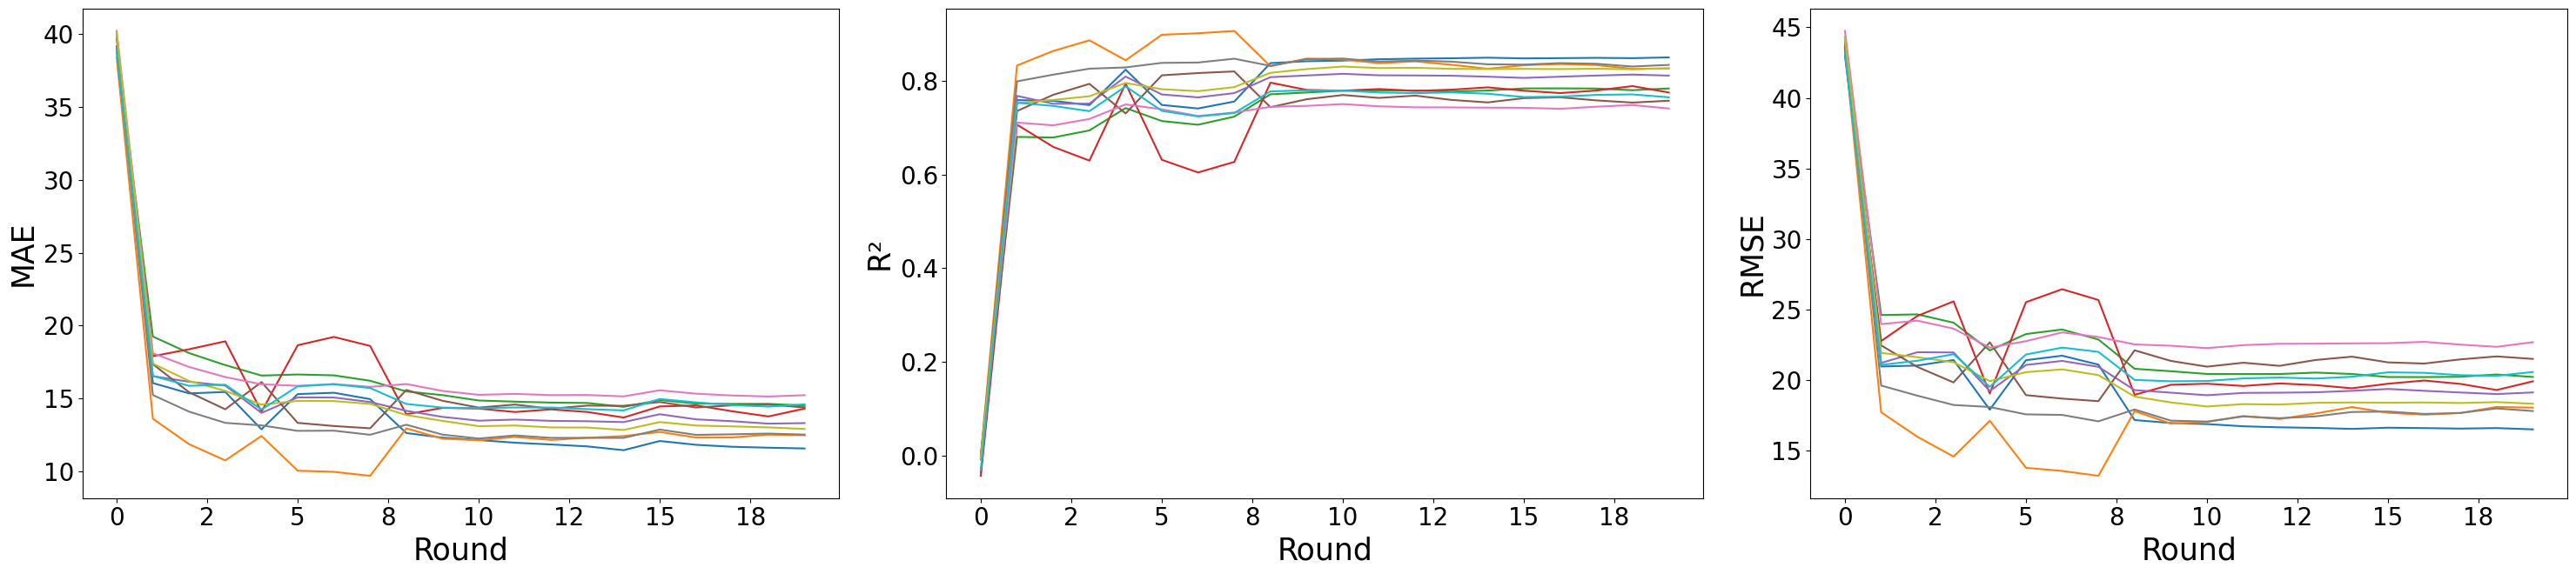

<Figure size 640x480 with 0 Axes>

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 7))
plt.rcParams.update({'font.size': 20})

# Plot MAE
ax1.plot(global_stats_mae_4[global_stats_mae_4.columns[1:11]], label='train')
ax1.set_ylabel('MAE', fontsize=25)
ax1.set_xlabel('Round', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Plot R² instead of MAP
ax2.plot(global_stats_r2_4[global_stats_r2_4.columns[1:11]], label='train')
ax2.set_ylabel('R²', fontsize=25)
ax2.set_xlabel('Round', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Plot RMSE
ax3.plot(global_stats_rmse_4[global_stats_rmse_4.columns[1:11]], label='train')
ax3.set_ylabel('RMSE', fontsize=25)
ax3.set_xlabel('Round', fontsize=25)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.tight_layout()
plt.show()
pyplot.savefig(f'federated-KRUM_{EPOCHS}_{comms_round}.png', bbox_inches='tight', dpi=400)

In [14]:
print('size of model: ', sys.getsizeof(global_model.get_weights()))

size of model:  184


### Calculating the average metrics across all rounds and storing them in new columns

In [15]:
global_stats_mae_4['A'] = (global_stats_mae_4['0'] + global_stats_mae_4['1'] + global_stats_mae_4['2'] + global_stats_mae_4['3'] +
                         global_stats_mae_4['4'] + global_stats_mae_4['5'] + global_stats_mae_4['6'] + global_stats_mae_4['7'] +
                         global_stats_mae_4['8'] + global_stats_mae_4['9'] + global_stats_mae_4['test']) / 11

global_stats_r2_4['A'] = (global_stats_r2_4['0'] + global_stats_r2_4['1'] + global_stats_r2_4['2'] + global_stats_r2_4['3'] +
                          global_stats_r2_4['4'] + global_stats_r2_4['5'] + global_stats_r2_4['6'] + global_stats_r2_4['7'] +
                          global_stats_r2_4['8'] + global_stats_r2_4['9'] + global_stats_r2_4['test']) / 11

global_stats_rmse_4['A'] = (global_stats_rmse_4['0'] + global_stats_rmse_4['1'] + global_stats_rmse_4['2'] + global_stats_rmse_4['3'] +
                          global_stats_rmse_4['4'] + global_stats_rmse_4['5'] + global_stats_rmse_4['6'] + global_stats_rmse_4['7'] +
                          global_stats_rmse_4['8'] + global_stats_rmse_4['9'] + global_stats_rmse_4['test']) / 11

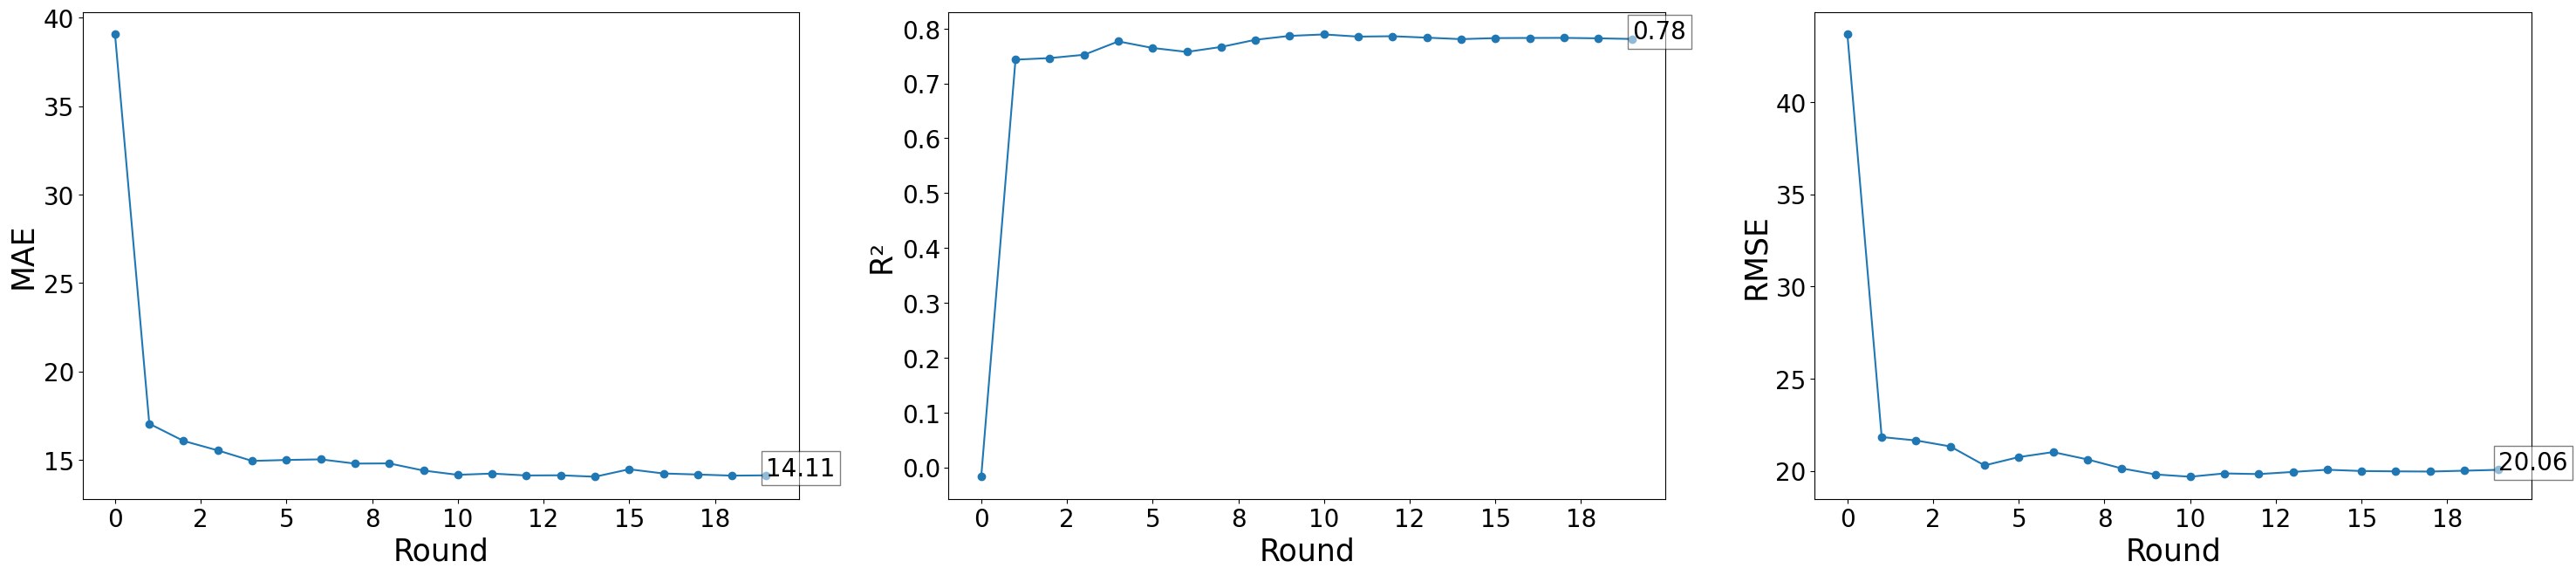

<Figure size 640x480 with 0 Axes>

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 7))
plt.rcParams.update({'font.size': 20})

# Plot MAE
ax1.plot(global_stats_mae_4['A'], label='train', marker='o')
ax1.set_ylabel('MAE', fontsize=25)
ax1.set_xlabel('Round', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Plot R²
ax2.plot(global_stats_r2_4['A'], label='train', marker='o')
ax2.set_ylabel('R²', fontsize=25)
ax2.set_xlabel('Round', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Plot RMSE
ax3.plot(global_stats_rmse_4['A'], label='train', marker='o')
ax3.set_ylabel('RMSE', fontsize=25)
ax3.set_xlabel('Round', fontsize=25)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Add text annotations for the last round values
round_idx = len(global_stats_mae_4) - 1
ax1.text(round_idx, global_stats_mae_4['A'][round_idx], f'{global_stats_mae_4["A"][round_idx]:.2f}', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
ax2.text(round_idx, global_stats_r2_4['A'][round_idx], f'{global_stats_r2_4["A"][round_idx]:.2f}', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
ax3.text(round_idx, global_stats_rmse_4['A'][round_idx], f'{global_stats_rmse_4["A"][round_idx]:.2f}', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

plt.tight_layout()
plt.show()

pyplot.savefig(f'federated-KRUM-train{EPOCHS}_{comms_round}.png', bbox_inches='tight', dpi=400)

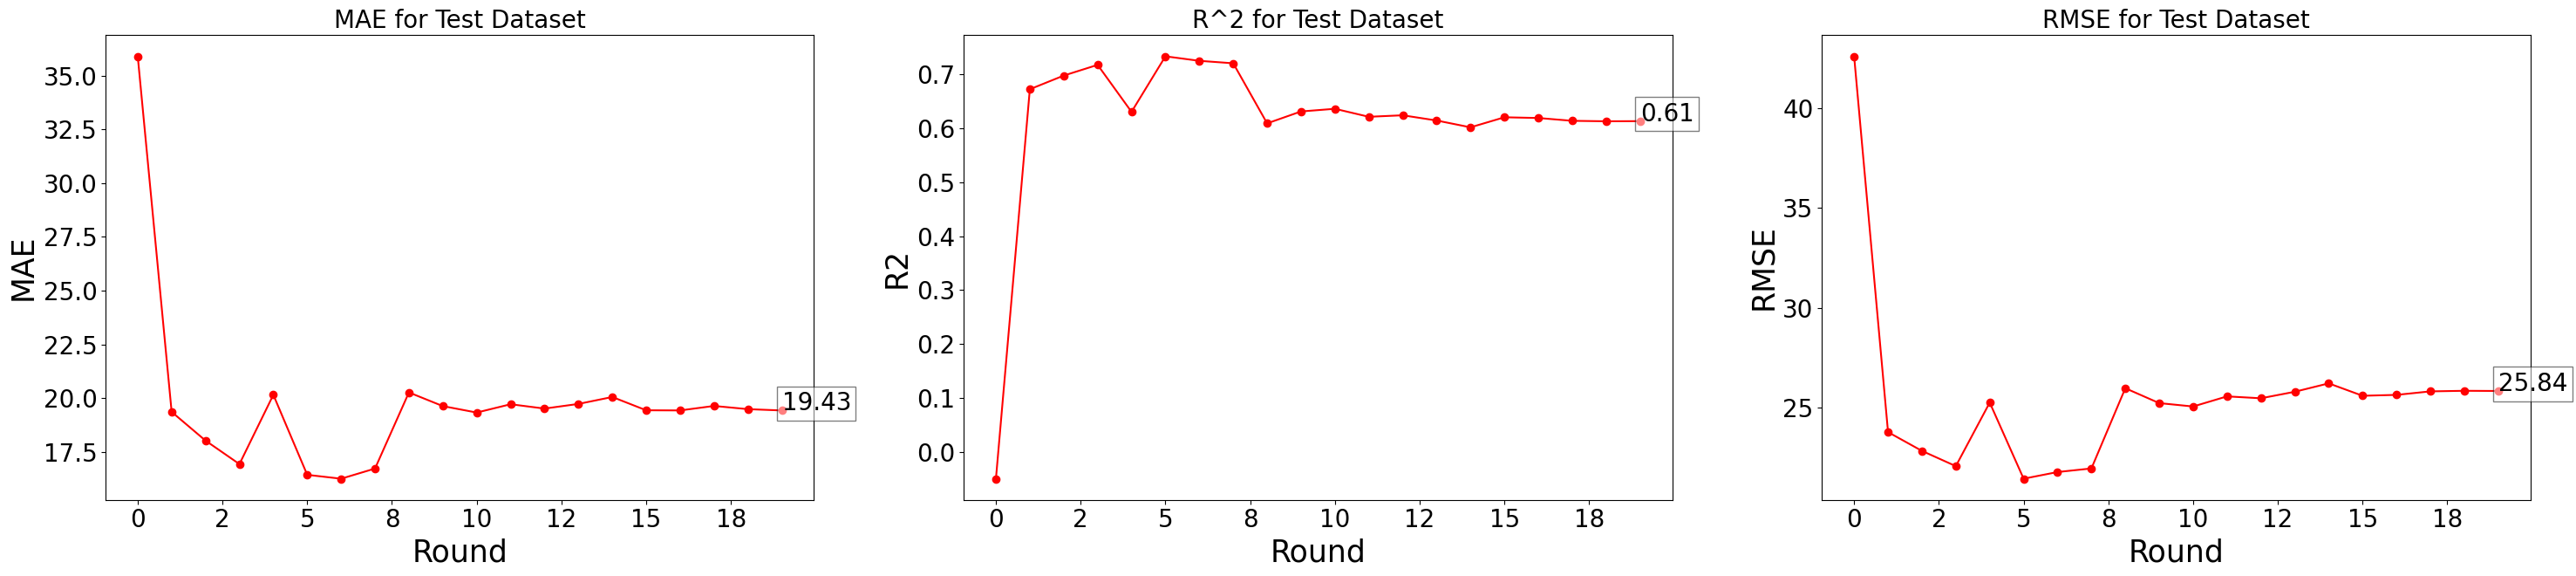

<Figure size 640x480 with 0 Axes>

In [17]:
fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(30, 7))
plt.rcParams.update({'font.size': 20})

ax1.plot(global_stats_mae_4['test'], label='test', marker='o', color='red')
ax1.set_ylabel('MAE', fontsize=25)
ax1.set_xlabel('Round', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax2.plot(global_stats_r2_4['test'], label='test', marker='o', color='red')
ax2.set_ylabel('R2', fontsize=25)
ax2.set_xlabel('Round', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax3.plot(global_stats_rmse_4['test'], label='test', marker='o', color='red')
ax3.set_ylabel('RMSE', fontsize=25)
ax3.set_xlabel('Round', fontsize=25)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

round_idx = len(global_stats_mae_4) - 1  
ax1.text(round_idx, global_stats_mae_4['test'][round_idx], f'{global_stats_mae_4["test"][round_idx]:.2f}', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
ax2.text(round_idx, global_stats_r2_4['test'][round_idx], f'{global_stats_r2_4["test"][round_idx]:.2f}', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
ax3.text(round_idx, global_stats_rmse_4['test'][round_idx], f'{global_stats_rmse_4["test"][round_idx]:.2f}', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

ax1.set_title('MAE for Test Dataset', fontsize=20)
ax2.set_title('R^2 for Test Dataset', fontsize=20)
ax3.set_title('RMSE for Test Dataset', fontsize=20)

plt.tight_layout()

plt.show()
pyplot.savefig(f'global-KRUM-test{EPOCHS}_{comms_round}.png', bbox_inches='tight', dpi=400)

In [18]:
global_stats_mae_4.to_csv('global_stats_mae_KRUM.csv', index=False)
global_stats_r2_4.to_csv('global_stats_r2_KRUM.csv', index=False)
global_stats_rmse_4.to_csv('global_stats_rmse_KRUM.csv', index=False)